In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# Object masks in images from prompts with SAM 2


Segment Anything Model 2 (SAM 2) predicts object masks given prompts that indicate the desired object. The model first converts the image into an image embedding that allows high quality masks to be efficiently produced from a prompt.

The `SAM2ImagePredictor` class provides an easy interface to the model for prompting the model. It allows the user to first set an image using the `set_image` method, which calculates the necessary image embeddings. Then, prompts can be provided via the `predict` method to efficiently predict masks from those prompts. The model can take as input both point and box prompts, as well as masks from the previous iteration of prediction.


<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/sam2/blob/main/notebooks/image_predictor_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


## Environment Set-up


If running locally using jupyter, first install `sam2` in your environment using the [installation instructions](https://github.com/facebookresearch/sam2#installation) in the repository.

If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'. Note that it's recommended to use **A100 or L4 GPUs when running in Colab** (T4 GPUs might also work, but could be slow and might run out of memory in some cases).


In [1]:
using_colab = False

In [2]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/sam2.git'

    !mkdir -p images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/sam2/main/notebooks/images/truck.jpg
    !wget -P images https://raw.githubusercontent.com/facebookresearch/sam2/main/notebooks/images/groceries.jpg

    !mkdir -p ../checkpoints/
    !wget -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt

## Set-up


Necessary imports and helper functions for displaying points, boxes, and masks.


In [3]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

In [4]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cpu


In [5]:
np.random.seed(3)

def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2) 
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))    

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        print(f"Mask shape: {mask.shape}")
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

## Example image


In [60]:
image = Image.open('images/parquery.jpg')
image = np.array(image.convert("RGB"))

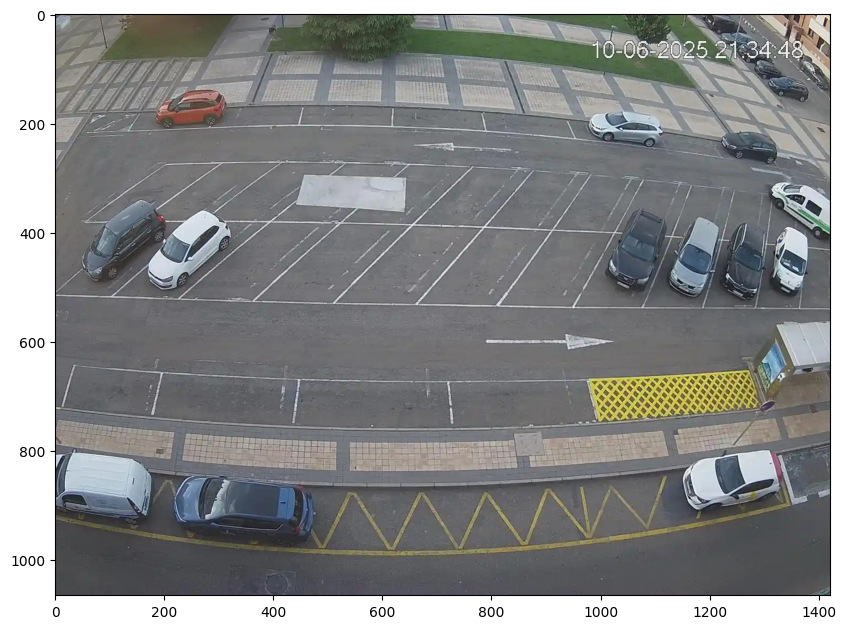

In [62]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('on')
plt.show()

## Selecting objects with SAM 2


First, load the SAM 2 model and predictor. Change the path below to point to the SAM 2 checkpoint. Running on CUDA and using the default model are recommended for best results.


In [63]:
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

sam2_checkpoint = "../checkpoints/sam2_hiera_large.pt"
model_cfg = "../sam2/configs/sam2/sam2_hiera_l.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)

predictor = SAM2ImagePredictor(sam2_model)

Process the image to produce an image embedding by calling `SAM2ImagePredictor.set_image`. `SAM2ImagePredictor` remembers this embedding and will use it for subsequent mask prediction.


In [64]:
predictor.set_image(image)

To select the truck, choose a point on it. Points are input to the model in (x,y) format and come with labels 1 (foreground point) or 0 (background point). Multiple points can be input; here we use only one. The chosen point will be shown as a star on the image.


In [65]:
input_points = np.array([
    [210, 302],  #1
    [302, 315],  #2
    [409, 315],  #3
    [534, 296],  #4
    [658, 295],  #5
    [786, 309],  #6
    [895, 313],  #7
    [1002, 313], #8
    [1111, 343], #9
    [1214, 310], #10
    [1290, 332], #11
    [1360, 373], #12

    [134, 408],  #1
    [244, 426],  #2
    [373, 422],  #3
    [510, 426],  #4
    [663, 458],  #5
    [801, 447],  #6
    [925, 446],  #7
    [1067, 450], #8
    [1177, 423], #9
    [1264, 446], #10
    [1347, 460], #11
    [1410, 463], #12
])
input_label = np.array([1])

In [220]:
input_points = np.array([
    [361, 261],  #1
    [555, 254],  #2
    [388, 195],  #3 
    [575, 200],  #4
    [350, 520],  #5
    [553, 235],  #6
    [855, 446],  #7
    [958, 437],  #8
])
input_label = np.array([1])

In [181]:
input_points = np.array([
    [37, 129],  #1
    [73, 85],   #2
    [97, 87],   #3 
    [130, 60],  #4
    [270, 50],  #5
    [310, 80],  #6     
    [344, 80],  #7    
    [378, 120], #8
    [380, 132], #9
    [390, 132], #10
    [382, 213], #11
    [374, 220], #12
    [350, 253], #13
    [312, 273], #14
    [260, 300], #15
    [139, 282], #16
    [94, 259],  #17
    [70, 246],  #18
    [43, 222],  #19
    [33, 216]   #20
])
input_label = np.array([1])

In [96]:
input_points = np.array([
    [212, 362],
    [126, 348],
    [68, 272],
    [56, 186],
    [89, 113],
    [147, 63],
    [198, 52],
    [265, 61],
    [296, 73],
    [319, 93],
    [354, 152],
    [363, 231],
    [344, 288],
    [293, 354],
    [272, 362]
])
input_label = np.array([1])

In [89]:
input_points = np.array([
    [98, 437],
    [453, 332],
    [610, 287],
    [920, 421]
])
input_label = np.array([1])

In [69]:
input_points = np.array([
    [114, 103],
    [195, 102],
    [300, 107],
    [400, 110],
    [505, 110],
    [590, 129],
    [670, 126],
    [112, 162],
    [162, 167],
    [220, 176],
    [287, 175],
    [363, 179],
])
input_label = np.array([1])

In [ ]:
input_points = np.array([
    [200, 170],
    [360, 160],
    [537, 192],
    [706, 195],
    [900, 190],
    [1018, 219],
    [1150, 244],
    [170, 310],
    [290, 290],
    [400, 290],
    [480, 310],
    [650, 310],
    [780, 310],
    [910, 310],
    [995, 350],
    [1108, 340],
    [1200, 350],
    [1280, 350],
    [1350, 350],
    [50, 430],
    [140, 420],
    [250, 430],
    [370, 430],
    [510, 440],
    [660, 430],
    [760, 460],
    [940, 450],
    [1070, 450],
    [1170, 450],
    [1260, 450],
    [1350, 450],
    [1410, 450],
    [70, 670],
    [300, 670],
    [580, 670],
    [866, 721],
    [1160, 670],
    [350, 900]
])
input_label = np.array([1])

In [ ]:
# for idx, (py, px) in enumerate(input_points):
#     # ─────────────────────────────────────────────────────────────────────────────────
#     # (3-1) 단일 포인트를 (1, 2) 형태로 만들어 주어야 show_points 함수가 동작합니다.
#     single_point = np.array([[py, px]])  # e.g. [[50, 70]] 형태
#     single_label = np.array([1])         # 이 점을 양성(1)으로 처리 (배경점이 없을 경우)
#     # ─────────────────────────────────────────────────────────────────────────────────

#     # (3-2) 이제 화면에 그림을 띄우고, show_points를 호출
#     plt.figure(figsize=(6, 6))
#     plt.imshow(image)  # 원본 이미지를 먼저 그린다

#     # show_points 함수는 아래와 같은 시그니처를 가정합니다:
#     #   def show_points(coords, labels, ax, marker_size=375):
#     # 따라서 단일 포인트라도 coords가 (1,2) 형태, labels가 (1,) 형태여야 한다.
#     show_points(single_point, single_label, plt.gca(), marker_size=200)

#     # (3-3) 제목에 “몇 번째 점인지”와 “좌표”를 표시
#     plt.title(f"Point #{idx+1} → (y={py}, x={px})", fontsize=14)

#     # (3-4) 축 표시 여부를 결정 (원하면 'off'로 해도 무방)
#     plt.axis('on')  

#     # (3-5) 최종 화면 출력
#plt.show()

In [66]:
print(predictor._features["image_embed"].shape, predictor._features["image_embed"][-1].shape)

torch.Size([1, 256, 64, 64]) torch.Size([256, 64, 64])


Predict with `SAM2ImagePredictor.predict`. The model returns masks, quality predictions for those masks, and low resolution mask logits that can be passed to the next iteration of prediction.


첫 번째 마스크의 픽셀 개수: 671520
첫 번째 마스크의 픽셀 개수: 671520.0
idx: 1, [X] Occupied Count: 0, Empty Count: 1


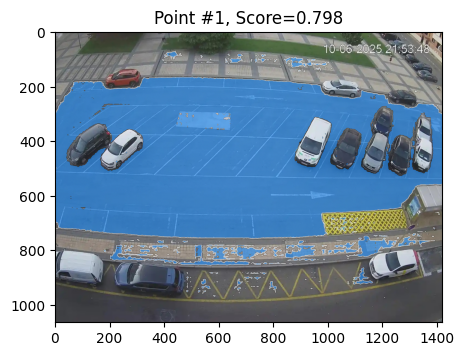

첫 번째 마스크의 픽셀 개수: 639364
첫 번째 마스크의 픽셀 개수: 639364.0
idx: 2, [X] Occupied Count: 0, Empty Count: 2


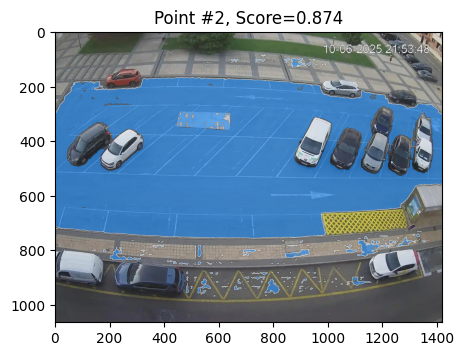

첫 번째 마스크의 픽셀 개수: 637682
첫 번째 마스크의 픽셀 개수: 637682.0
idx: 3, [X] Occupied Count: 0, Empty Count: 3


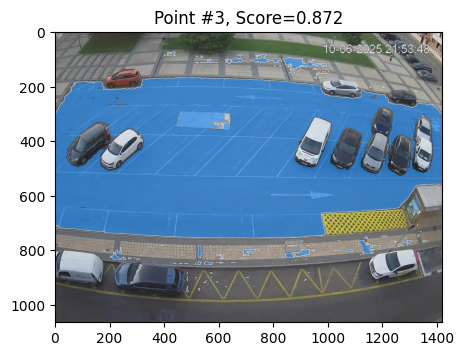

첫 번째 마스크의 픽셀 개수: 11734
첫 번째 마스크의 픽셀 개수: 11734.0
idx: 4, [O] Occupied Count: 1, Empty Count: 3


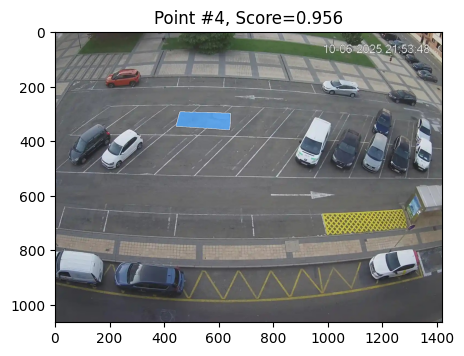

첫 번째 마스크의 픽셀 개수: 624760
첫 번째 마스크의 픽셀 개수: 624760.0
idx: 5, [X] Occupied Count: 1, Empty Count: 4


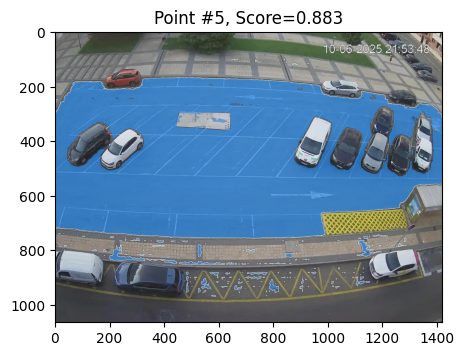

첫 번째 마스크의 픽셀 개수: 624750
첫 번째 마스크의 픽셀 개수: 624750.0
idx: 6, [X] Occupied Count: 1, Empty Count: 5


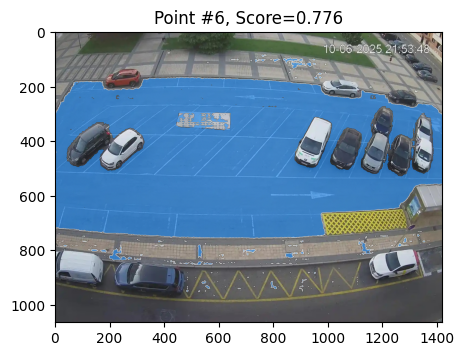

첫 번째 마스크의 픽셀 개수: 647285
첫 번째 마스크의 픽셀 개수: 647285.0
idx: 7, [X] Occupied Count: 1, Empty Count: 6


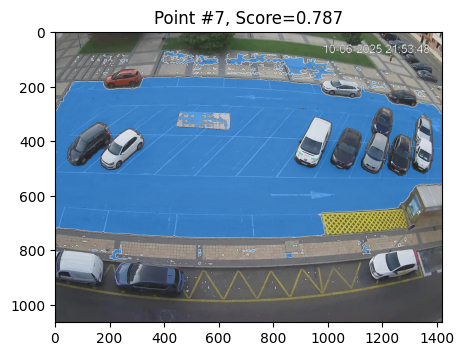

첫 번째 마스크의 픽셀 개수: 702417
첫 번째 마스크의 픽셀 개수: 702417.0
idx: 8, [X] Occupied Count: 1, Empty Count: 7


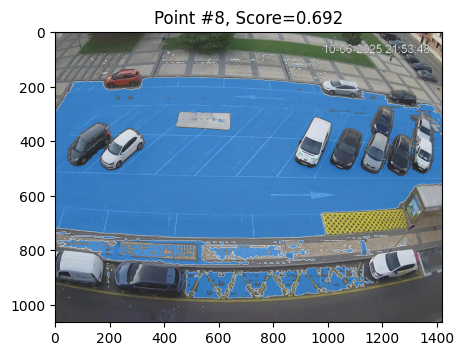

첫 번째 마스크의 픽셀 개수: 685485
첫 번째 마스크의 픽셀 개수: 685485.0
idx: 9, [X] Occupied Count: 1, Empty Count: 8


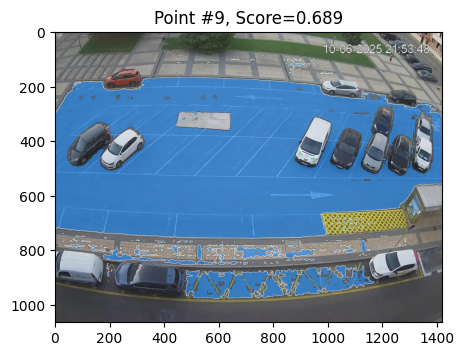

첫 번째 마스크의 픽셀 개수: 5166
첫 번째 마스크의 픽셀 개수: 5166.0
idx: 10, [O] Occupied Count: 2, Empty Count: 8


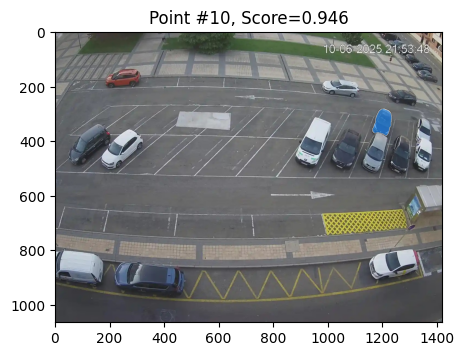

첫 번째 마스크의 픽셀 개수: 629100
첫 번째 마스크의 픽셀 개수: 629100.0
idx: 11, [X] Occupied Count: 2, Empty Count: 9


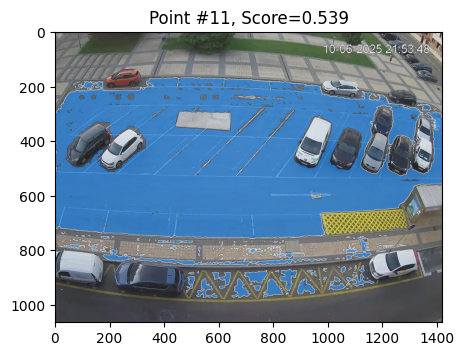

첫 번째 마스크의 픽셀 개수: 3492
첫 번째 마스크의 픽셀 개수: 3492.0
idx: 12, [O] Occupied Count: 3, Empty Count: 9


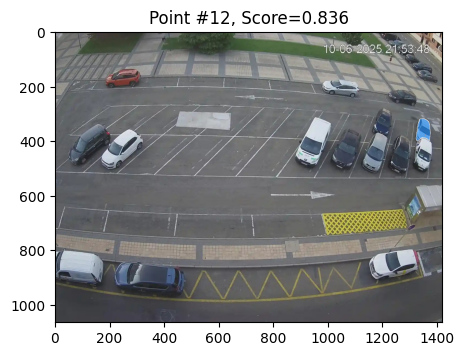

첫 번째 마스크의 픽셀 개수: 12425
첫 번째 마스크의 픽셀 개수: 12425.0
idx: 13, [O] Occupied Count: 4, Empty Count: 9


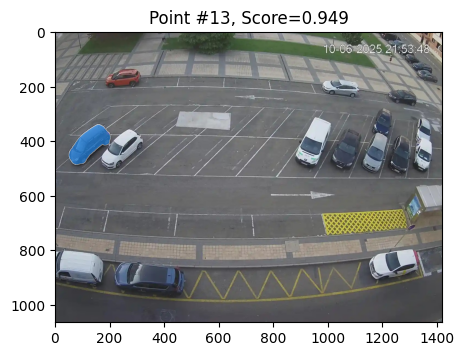

첫 번째 마스크의 픽셀 개수: 12712
첫 번째 마스크의 픽셀 개수: 12712.0
idx: 14, [O] Occupied Count: 5, Empty Count: 9


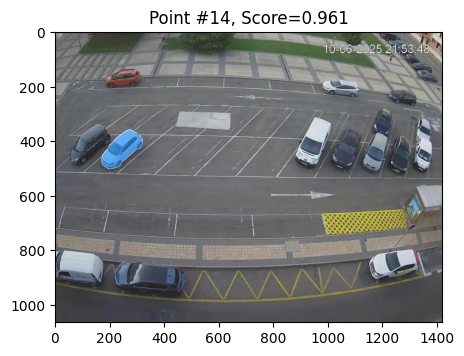

첫 번째 마스크의 픽셀 개수: 613346
첫 번째 마스크의 픽셀 개수: 613346.0
idx: 15, [X] Occupied Count: 5, Empty Count: 10


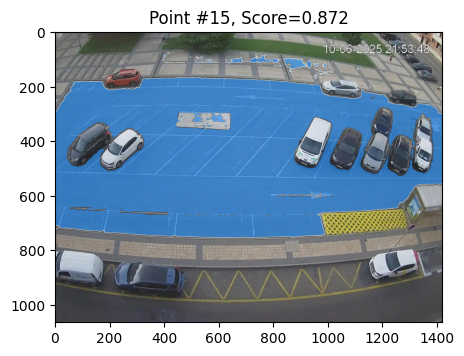

첫 번째 마스크의 픽셀 개수: 619360
첫 번째 마스크의 픽셀 개수: 619360.0
idx: 16, [X] Occupied Count: 5, Empty Count: 11


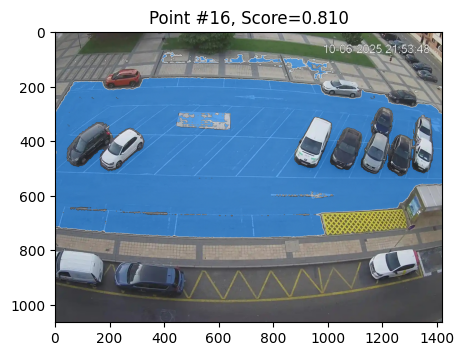

첫 번째 마스크의 픽셀 개수: 624809
첫 번째 마스크의 픽셀 개수: 624809.0
idx: 17, [X] Occupied Count: 5, Empty Count: 12


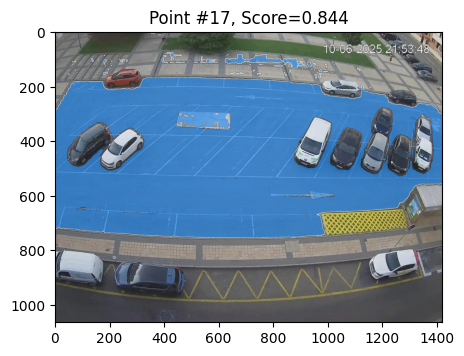

첫 번째 마스크의 픽셀 개수: 640758
첫 번째 마스크의 픽셀 개수: 640758.0
idx: 18, [X] Occupied Count: 5, Empty Count: 13


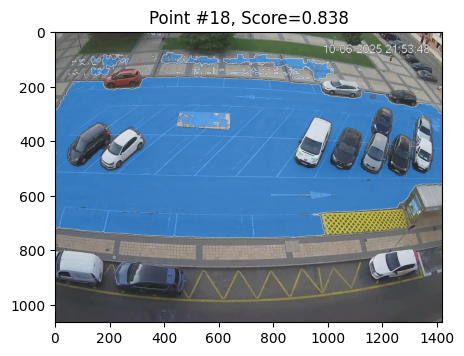

첫 번째 마스크의 픽셀 개수: 14326
첫 번째 마스크의 픽셀 개수: 14326.0
idx: 19, [O] Occupied Count: 6, Empty Count: 13


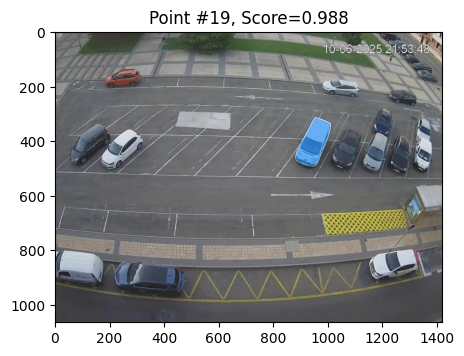

첫 번째 마스크의 픽셀 개수: 10630
첫 번째 마스크의 픽셀 개수: 10630.0
idx: 20, [O] Occupied Count: 7, Empty Count: 13


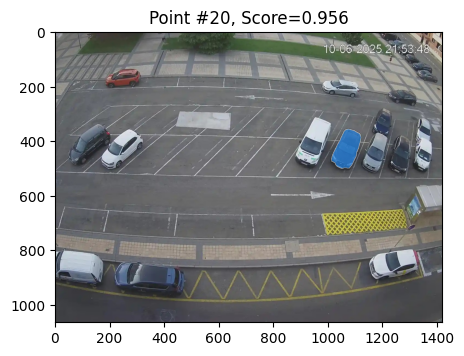

첫 번째 마스크의 픽셀 개수: 9188
첫 번째 마스크의 픽셀 개수: 9188.0
idx: 21, [O] Occupied Count: 8, Empty Count: 13


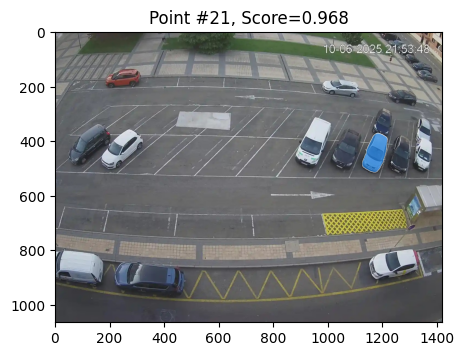

첫 번째 마스크의 픽셀 개수: 8024
첫 번째 마스크의 픽셀 개수: 8024.0
idx: 22, [O] Occupied Count: 9, Empty Count: 13


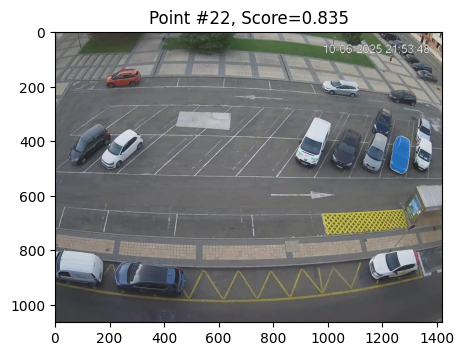

첫 번째 마스크의 픽셀 개수: 6496
첫 번째 마스크의 픽셀 개수: 6496.0
idx: 23, [O] Occupied Count: 10, Empty Count: 13


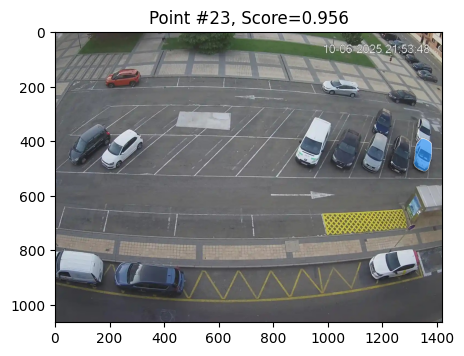

첫 번째 마스크의 픽셀 개수: 501
첫 번째 마스크의 픽셀 개수: 501.0
idx: 24, [X] Occupied Count: 10, Empty Count: 14


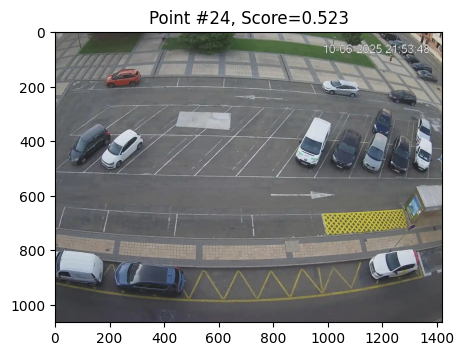

Occupied Count:  10
Empty Count   :  14


In [56]:
occupiedCount = 0 
emptyCount = 0

#                   1     2     3     4     5     6     7     8    9    10   11   12    13    14    15    16    17    18    19   20
lower_thresholds = [1000,  1000,  1000,  1000,  1000,  1000,  1000,  1000,  1000,  1000,  1000,  1000,  1000,  1000,  1000,  1000,  1000,  1000,  1000,  1000,  1000,  1000,  1000,  1000 ]
upper_thresholds = [15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000, 15000]
score_thresholds = [0.7,   0.7,   0.7,   0.7,   0.7,   0.7,   0.7,   0.7,   0.7,   0.7,   0.7,   0.7,    0.7,  0.7,   0.7,   0.7,   0.7,   0.7,   0.7,   0.7,   0.7,   0.7,   0.7,   0.7  ]

second_point_for = {
    # 6: [397, 204],  # idx=15(16번째) --> 두 번째 좌표는 [144, 303]
    # 16: [102, 287],  # idx=16(17번째) --> 두 번째 좌표는 [ 95, 277]
    # 17: [56, 250],  # idx=16(17번째) --> 두 번째 좌표는 [ 95, 277]
}

for idx, pt in enumerate(input_points):
    
    if idx in second_point_for:
        # 첫 번째 좌표: input_points[15] (예: [144, 296])
        # 두 번째 좌표: 예시로 [200, 350] 을 추가 (사용자 상황에 맞춰 바꾸세요)
        first_pt = input_points[idx].tolist()  # 예: [144, 296] 또는 [ 95, 270]
        # 2) 두 번째 좌표는 미리 정의해 둔 값
        second_pt = second_point_for[idx]       # ex: [144, 303] 또는 [95, 277]

        single_point = np.array([first_pt], dtype=np.int32)  # shape = (1, 2)
        single_label = np.array([1], dtype=np.int32)         # (1,)

        # 3) 두 좌표를 합쳐서 (2,2) 모양의 배열로 만든다.
        point_pair = np.array([ first_pt, second_pt ], dtype=np.int32)
        label_pair = np.array([1, 1], dtype=np.int32)  # 둘 다 양성(1)이라고 가정

        # SAM2 predict 호출
        masks, scores, _ = predictor.predict(
            point_coords     = point_pair,
            point_labels     = label_pair,
            multimask_output = False
        )

        # 두 번째 인자로 넘긴 포인트가 두 개이므로, masks와 scores도 각각 길이 2 이상의 배열이 나옵니다.
        # 만약 multimask_output=False로 하면 masks.shape = (2, H, W) 또는 그 이상이 될 수 있으므로,
        # 보통 첫 번째 mask만 써야 한다면 masks[0], scores[0]을 그대로 사용합니다.
        mask_2d    = masks[0]    # 첫 번째 마스크
        score_val  = scores[0] 

        pixel_count = np.count_nonzero(mask_2d)
        pixel_count2 = mask_2d.sum()

        print(f"첫 번째 마스크의 픽셀 개수: {pixel_count}")   # 방법 A 결과
        print(f"첫 번째 마스크의 픽셀 개수: {pixel_count2}")  # 방법 B 결과

        lower = lower_thresholds[idx]
        upper = upper_thresholds[idx]
        # (옵션) score threshold 불러오기
        score_thresh = score_thresholds[idx]

        if score_val >= score_thresh and pixel_count > lower and pixel_count < upper:
            occupiedCount += 1
            print(f"idx: {idx+1}, [O] Occupied Count: {occupiedCount}, Empty Count: {emptyCount}")
        else:
            emptyCount += 1
            print(f"idx: {idx+1}, [X] Occupied Count: {occupiedCount}, Empty Count: {emptyCount}")

    else:
        single_point = np.array([pt])          # (1, 2)
        single_label = np.array([1])           # (1,), 양성(1)

        masks, scores, _ = predictor.predict(
            point_coords     = single_point,
            point_labels     = single_label,
            multimask_output = False
        )
        mask_2d = masks[0]
        score_val = scores[0]

        pixel_count = np.count_nonzero(mask_2d)
        pixel_count2 = mask_2d.sum()

        print(f"첫 번째 마스크의 픽셀 개수: {pixel_count}")   # 방법 A 결과
        print(f"첫 번째 마스크의 픽셀 개수: {pixel_count2}")  # 방법 B 결과

        lower = lower_thresholds[idx]
        upper = upper_thresholds[idx]
        # (옵션) score threshold 불러오기
        score_thresh = score_thresholds[idx]

        if score_val >= score_thresh and pixel_count > lower and pixel_count < upper:
            occupiedCount += 1
            print(f"idx: {idx+1}, [O] Occupied Count: {occupiedCount}, Empty Count: {emptyCount}")
        else:
            emptyCount += 1
            print(f"idx: {idx+1}, [X] Occupied Count: {occupiedCount}, Empty Count: {emptyCount}")

    
    # 화면에 띄우는 부분
    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    show_mask(mask_2d, plt.gca(), random_color=False, borders=True)
    #show_points(single_point, single_label, plt.gca(), marker_size=200)
    plt.title(f"Point #{idx+1}, Score={score_val:.3f}")
    plt.axis('on')
    plt.show()

print(f"Occupied Count:  {occupiedCount}")
print(f"Empty Count   :  {emptyCount}")
